<a href="https://colab.research.google.com/github/GauriGA/MSCBootcamp/blob/main/Backend_pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING LIBRARIES**

In [1]:
import numpy as np
import pandas as pd
import cv2
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import os

**IMPORTING DATASET DIRECTLY FROM KAGGLE**

In [2]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
! mkdir ~/.kaggle

In [5]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [6]:
! chmod 600 ~/.kaggle/kaggle.json


In [7]:
! kaggle competitions download 'Chest X-Ray Images (Pneumonia)'

403 - Forbidden - Permission 'competitions.participate' was denied


In [8]:
! pip install -q kaggle

In [9]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [11]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:33<00:00, 115MB/s] 
100% 2.29G/2.29G [00:33<00:00, 74.5MB/s]


In [12]:
! unzip /content/chest-xray-pneumonia.zip -d chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0442-

**LOADING THE DATASET**

In [13]:
train_data_dir = "/content/chest-xray-pneumonia/chest_xray/train"
val_data_dir = "/content/chest-xray-pneumonia/chest_xray/val"
test_data_dir = "/content/chest-xray-pneumonia/chest_xray/test"

**DATA VISUALIZATION AND PRE-PROCESSING**

**1. EXPLORATORY DATA ANALYSIS**<br>
The first step in our project is conducting an exploratory analysis, and look what the data has to offer. We start with loading in the data to check the images to get an idea about the differences in the x-ray imagaes between the 2 classes. All the data is stored online in kaggle.

Normal X-Rays From Validation Set: 1341 
Pneumonia X-Rays From Validation Set: 3875 


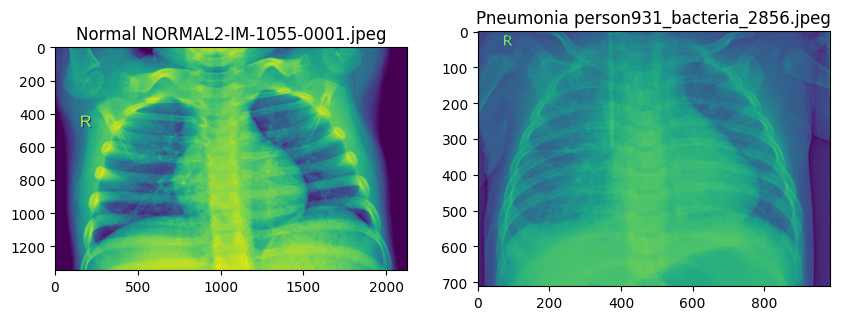

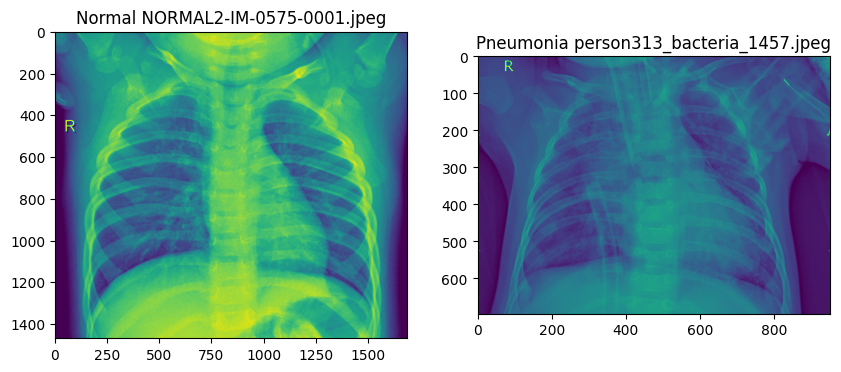

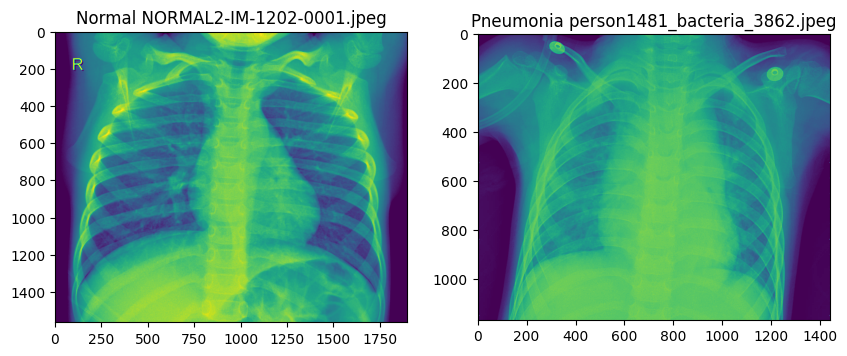

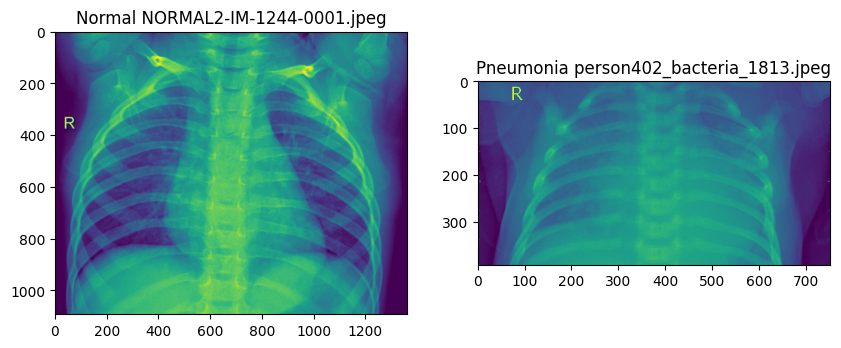

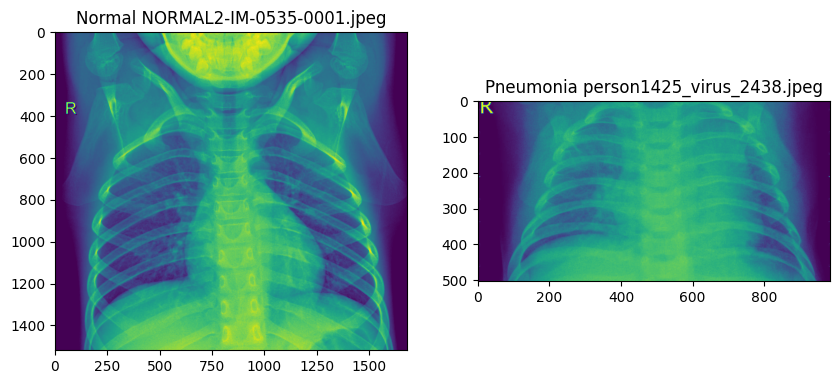

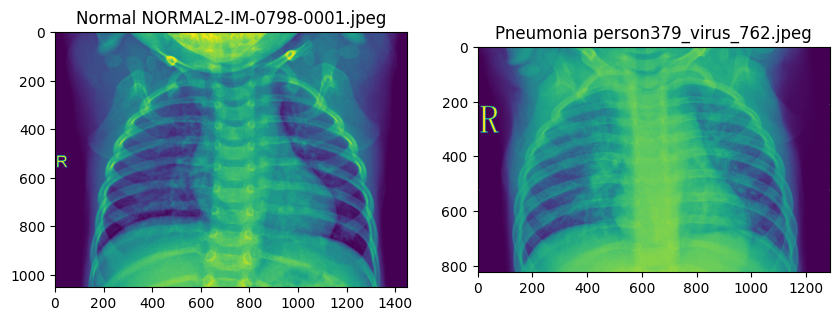

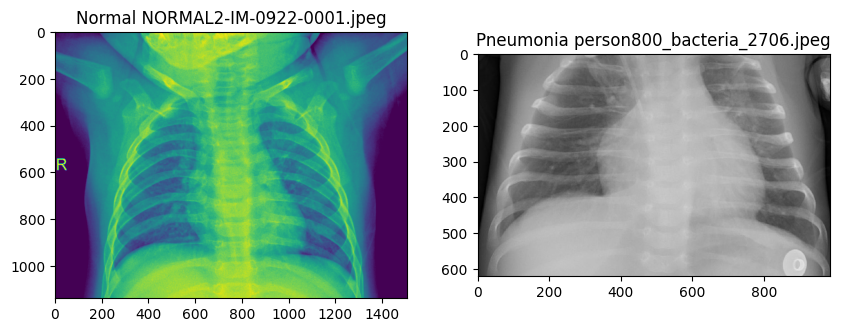

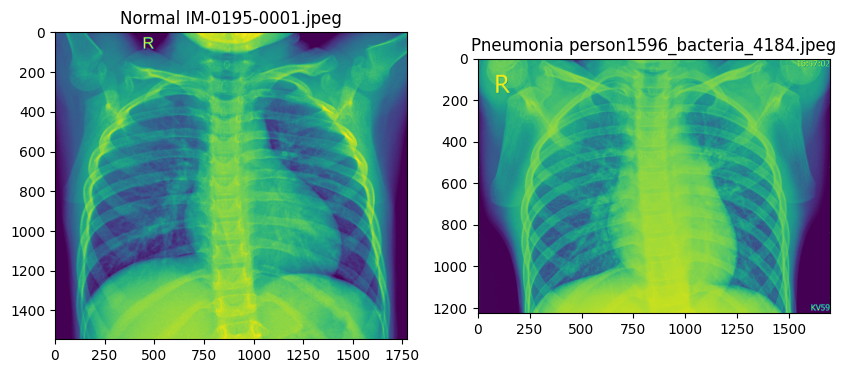

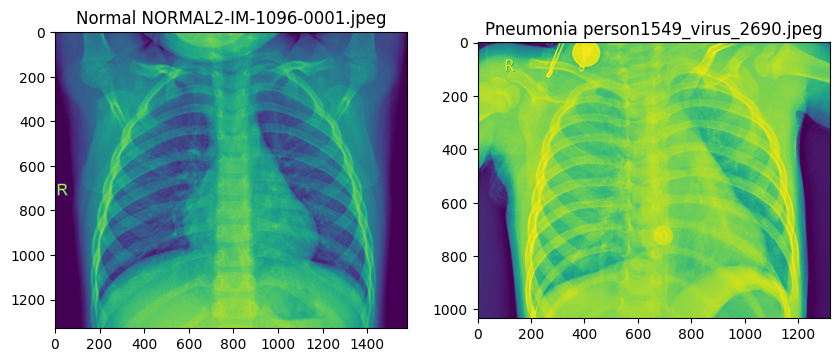

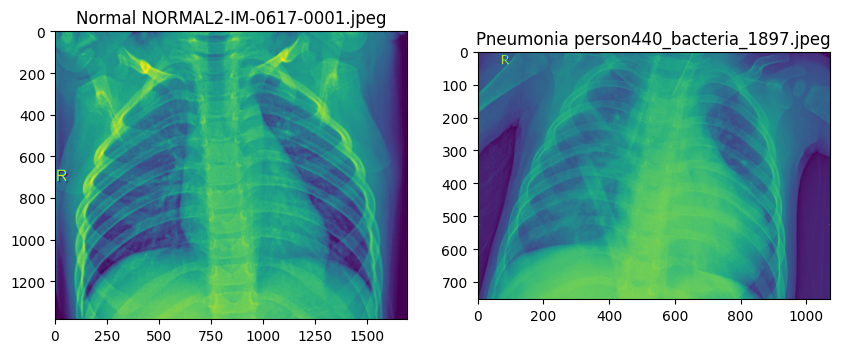

In [14]:
# Set up folders for normal cases and pneumonia cases wihtin our train data
train_n = train_data_dir + '/NORMAL/'
train_p = train_data_dir + '/PNEUMONIA/'

# Random normal picture from train set
print(f"Normal X-Rays From Validation Set: {len(os.listdir(train_n))} ")

## Select 10 normal pictures
norm_pic = os.listdir(train_n)[25:35]
norm_pic_address = [train_n + pic for pic in norm_pic]

# Random Pneumonia picture from train set
print(f"Pneumonia X-Rays From Validation Set: {len(os.listdir(train_p))} ")

## Select 10 Pneumonia pictures
pneumonia_pic =  os.listdir(train_p)[40:50]
pneumonia_address = [train_p + pic for pic in pneumonia_pic]

for i in range(0,10):
    # Load the images
    norm_img = Image.open(norm_pic_address[i])
    pneumonia_img = Image.open(pneumonia_address[i])

    #Let's plt these images
    ## plot normal picture
    f = plt.figure(figsize= (10,6))
    a1 = f.add_subplot(1,2,1)
    img_plot = plt.imshow(norm_img)
    a1.set_title(f'Normal {norm_pic[i]}')

    ## plot pneumonia picture
    a2 = f.add_subplot(1, 2, 2)
    img_plot = plt.imshow(pneumonia_img)
    a2.set_title(f'Pneumonia {pneumonia_pic[i]}')

As we see there is a large bias towards Pneumonia data in the training set, only 25% of the data is normal data. If we built a classifier which would always label our data 1 we still would obtain a 75% accuracy. So we want to think about this, looking at false negatives is probably more informative of the model's performance. One way to deal with this issue is by adding class weights in to the layers.

In [15]:
# folder path
dir_path = r'/content/chest-xray-pneumonia/chest_xray/train/NORMAL'
count_train_n = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count_train_n += 1
print('File count:', count_train_n)

File count: 1341


In [16]:
# folder path
dir_path = r'/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA'
count_train_p = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count_train_p += 1
print('File count:', count_train_p)

File count: 3875


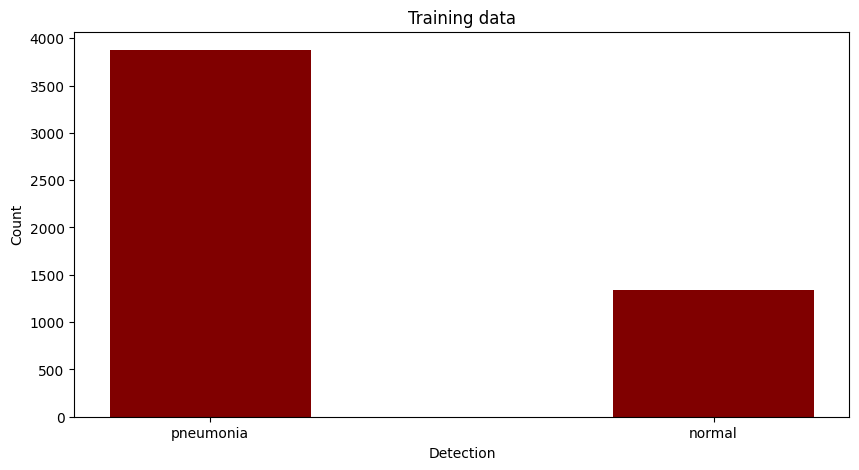

In [17]:
data = {'pneumonia':count_train_p, 'normal':count_train_n}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='maroon',
        width = 0.4)

plt.xlabel("Detection")
plt.ylabel("Count")
plt.title("Training data")
plt.show()

In [18]:
# folder path
dir_path = r'/content/chest-xray-pneumonia/chest_xray/test/NORMAL'
count_test_n = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count_test_n += 1
print('File count:', count_test_n)

File count: 234


In [19]:
# folder path
dir_path = r'/content/chest-xray-pneumonia/chest_xray/test/PNEUMONIA'
count_test_p = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count_test_p += 1
print('File count:', count_test_p)

File count: 390


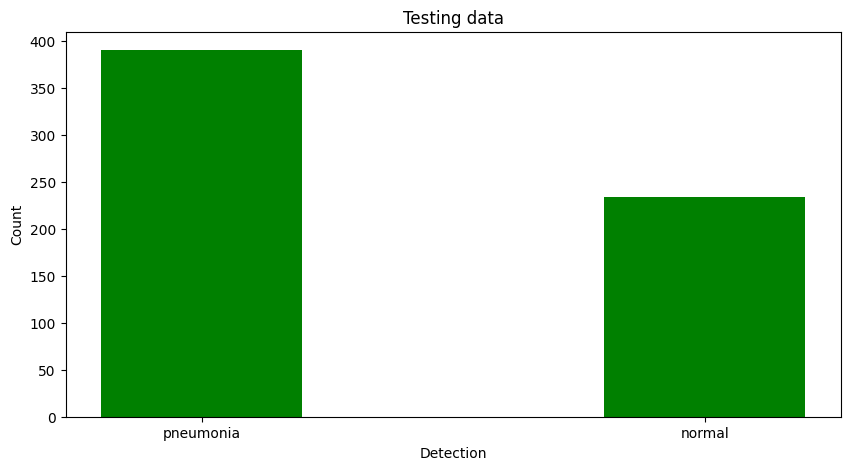

In [20]:
data = {'pneumonia':count_test_p, 'normal':count_test_n}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='green',
        width = 0.4)

plt.xlabel("Detection")
plt.ylabel("Count")
plt.title("Testing data")
plt.show()

In [21]:
# folder path
dir_path = r'/content/chest-xray-pneumonia/chest_xray/val/NORMAL'
count_val_n = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count_val_n += 1
print('File count:', count_val_n)

File count: 8


In [22]:
# folder path
dir_path = r'/content/chest-xray-pneumonia/chest_xray/val/PNEUMONIA'
count_val_p = 0
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        count_val_p += 1
print('File count:', count_val_p)

File count: 8


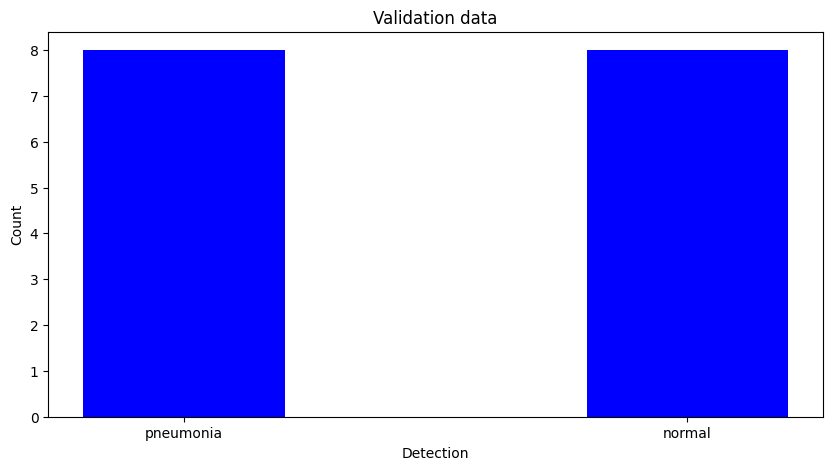

In [23]:
data = {'pneumonia':count_val_p, 'normal':count_val_n}
courses = list(data.keys())
values = list(data.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(courses, values, color ='blue',
        width = 0.4)

plt.xlabel("Detection")
plt.ylabel("Count")
plt.title("Validation data")
plt.show()

**2. PREPARE THE MODEL**

**2.1 Prepare the data<br>**
There are no files in the validation folder as we have it right now. To generate validation samples we do the following:
Split training data into train and validation (80:20) sets. To perform this specify validation_split parameter in ImageDataGenerator function. Set directory path to training directory so that the Generator can take data from training directory. Test generator Shuffle is set to FALSE. This is because, after predictions we want to plot our predictions to a Confusion Matrix and we want to be able to have one-one direct mapping of unshuffled samples.

In [24]:
#  Create a data augmentor
data_augmentor = ImageDataGenerator(samplewise_center=True, rescale=1./255, shear_range=0.2,zoom_range = 0.2,samplewise_std_normalization=True,validation_split=0.2)

# Set hyperparameters
target_size = (128,128)
target_dims = (128, 128, 3) # add channel for RGB
n_batch_size = 32

# Create datasets
train_generator = data_augmentor.flow_from_directory(train_data_dir,  target_size=target_size, subset='training',batch_size= n_batch_size,class_mode='binary')
val_generator = data_augmentor.flow_from_directory(train_data_dir, target_size=target_size,subset='validation',class_mode='binary')
test_generator = data_augmentor.flow_from_directory(test_data_dir, target_size=target_size,batch_size= 1,class_mode=None, shuffle=False)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**2.2 BUILD THE MODEL**<br>
Here we create the structure of our model, we use the following layers:

In [25]:
def initialize_model(name):
    model = Sequential(name=name)

    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=target_dims, padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.1))

    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(Dropout(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [26]:
model = initialize_model(name="basemodel")
model.summary()

Model: "basemodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 32, 32, 64)        0 

In [27]:
def compile_model(model):
    model.compile(optimizer="adam",loss='binary_crossentropy',metrics="binary_accuracy")
    return model

**2.3 REGULARIZATION**<br>
In order to prevent our model to overtrain we implement the following regularization measures.

In [28]:
model_baseline = initialize_model(name="baseline")
history_baseline = compile_model(model_baseline)

callback = [EarlyStopping(patience=5, monitor='val_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 2, factor=0.5, verbose=1),
            ModelCheckpoint("xray_model_v2.h5",save_best_only=True)]

**3. TRAIN THE MODEL**<br>
Now it's time to train our model!!

In [29]:
history_baseline = model_baseline.fit(train_generator,
                                      batch_size=n_batch_size,
                                      epochs=10,
                                      validation_data=val_generator,shuffle=True,
                                      callbacks=callback) #,class_weight=class_weights)

Epoch 1/10
131/131 [==============================] - ETA: 0s - loss: 0.3705 - binary_accuracy: 0.8330

131/131 [==============================] - 316s 2s/step - loss: 0.3705 - binary_accuracy: 0.8330 - val_loss: 0.2768 - val_binary_accuracy: 0.8677 - lr: 0.0010
Epoch 2/10
131/131 [==============================] - ETA: 0s - loss: 0.2228 - binary_accuracy: 0.9085

131/131 [==============================] - 315s 2s/step - loss: 0.2228 - binary_accuracy: 0.9085 - val_loss: 0.2001 - val_binary_accuracy: 0.9156 - lr: 0.0010
Epoch 3/10
131/131 [==============================] - ETA: 0s - loss: 0.1894 - binary_accuracy: 0.9243

131/131 [==============================] - 314s 2s/step - loss: 0.1894 - binary_accuracy: 0.9243 - val_loss: 0.1733 - val_binary_accuracy: 0.9204 - lr: 0.0010
Epoch 4/10
131/131 [==============================] - ETA: 0s - loss: 0.1868 - binary_accuracy: 0.9303

131/131 [==============================] - 305s 2s/step - loss: 0.1868 - binary_accuracy: 0.9303 - val_loss: 0.1608 - val_binary_accuracy: 0.9262 - lr: 0.0010
Epoch 5/10
131/131 [==============================] - ETA: 0s - loss: 0.1651 - binary_accuracy: 0.9406

131/131 [==============================] - 308s 2s/step - loss: 0.1651 - binary_accuracy: 0.9406 - val_loss: 0.1581 - val_binary_accuracy: 0.9386 - lr: 0.0010
Epoch 6/10
131/131 [==============================] - ETA: 0s - loss: 0.1560 - binary_accuracy: 0.9497

131/131 [==============================] - 309s 2s/step - loss: 0.1560 - binary_accuracy: 0.9497 - val_loss: 0.1546 - val_binary_accuracy: 0.9329 - lr: 0.0010
Epoch 7/10
131/131 [==============================] - ETA: 0s - loss: 0.1556 - binary_accuracy: 0.9490

131/131 [==============================] - 299s 2s/step - loss: 0.1556 - binary_accuracy: 0.9490 - val_loss: 0.1301 - val_binary_accuracy: 0.9492 - lr: 0.0010
Epoch 8/10
131/131 [==============================] - ETA: 0s - loss: 0.1465 - binary_accuracy: 0.9492

131/131 [==============================] - 303s 2s/step - loss: 0.1465 - binary_accuracy: 0.9492 - val_loss: 0.1163 - val_binary_accuracy: 0.9540 - lr: 0.0010
Epoch 9/10
131/131 [==============================] - ETA: 0s - loss: 0.1451 - binary_accuracy: 0.9533

131/131 [==============================] - 302s 2s/step - loss: 0.1451 - binary_accuracy: 0.9533 - val_loss: 0.1102 - val_binary_accuracy: 0.9626 - lr: 0.0010
Epoch 10/10
131/131 [==============================] - ETA: 0s - loss: 0.1509 - binary_accuracy: 0.9499

131/131 [==============================] - 312s 2s/step - loss: 0.1509 - binary_accuracy: 0.9499 - val_loss: 0.1139 - val_binary_accuracy: 0.9578 - lr: 0.0010


**4. EVALUATE THE MODEL**

In [30]:
scores = model_baseline.evaluate(val_generator)
scores

33/33 [==============================] - 31s 931ms/step - loss: 0.0942 - binary_accuracy: 0.9655


[0.09421776235103607, 0.9654842019081116]

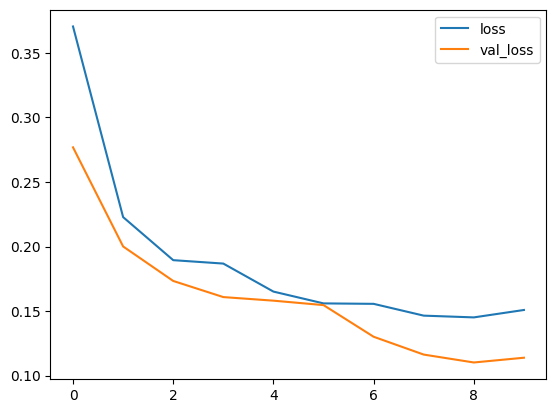

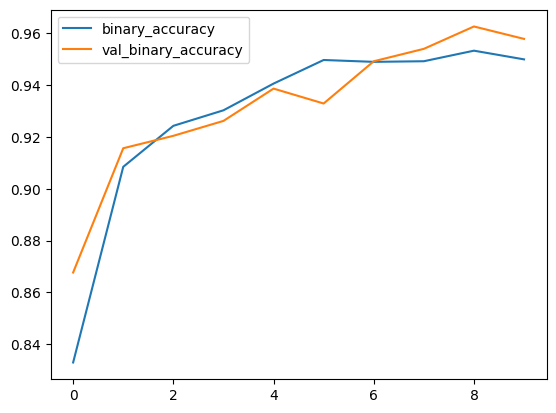

In [31]:
history_frame = pd.DataFrame(history_baseline.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [32]:
model.save("model.h5")